# Clustering

Clustering is an unsupervised machine learning technique usede to devide a group into cohorts. It is unsupervised because we do not give the model any labels; it just inspects the features and determines which samples are similar and belong in a cluster. 

## Kmeans

The k-means algorithm requires the user to pick the number of clusters 'K'. It then randomly chooses k centroids and assign each sample to a cluster based on a distance metric from the centroid. Following the assignement, it recalculates the centroid based on the center of every sample assigned to a label. It then repeats assigning samples to clusters based on the new centroids. After a few interations it should converge. 

Because clustering uses distance metrics to determine which samples are similar, the behaviour may change depending on the scale of the data. You can standardize the data and put all of the features on the same scale. Some have suggested that a SME might advise against standardizing if the scale hints that some features have more importance. We will standardize the data here in this example. 


In [2]:
import pandas as pd 

X = pd.read_excel('X.xls')
X.drop(columns = 'Unnamed: 0', inplace = True)

In [7]:
from sklearn.cluster import KMeans 

km = KMeans(2, random_state = 42)
km.fit(X)
KMeans(algorithm = 'auto', copy_x = True, init = 'k-means', max_iter = 300, n_clusters = 2, n_init = 10, n_jobs = 1, 
       precompute_distances = 'auto', random_state = 42, tol = 0.0001, verbose = 0)

KMeans(init='k-means', n_clusters=2, n_jobs=1, precompute_distances='auto',
       random_state=42)

After the model is trained, we can call `.predict` method to assign new samples to a cluster:

In [8]:
X_km = km.predict(X)
X_km

array([0, 0, 0, ..., 0, 0, 0])

__Instance parameters__

* `n_clusters = 8` Number of clusters to create.
* `init = 'kmeans++'` Initialization method.
* `n_init = 10` Number of times to run the algorithm with different centroids. Best score will win. 
* `max_iter = 300` Number of iterations for a run. 
* `tol = 0.0001` Tolerance until convergence.
* `precompute_distances = 'auto'` Precompute distances (takes more memory but it is faster). `auto` will precompute if `n_samples * n_clusters` is less than or equal to 12 million. 
* `verbosity = 0` Verbosity
* `random_state = None` Random seed
* `copy_x = True` Copy data before computing.
* `n_jobs = 1` Number of CPUs to use. 
* `algorithm = 'auto'` K-means algorithm. `full` works with sparse data, but `elkan` is more efficient. `auto` uses `elkan` with dense data. 


__Attributes__ 

* `cluster_centers_` Coordinates of centers
* `labels_` Labels for samples 
* `inertia_` Sum of squared distance to cluster centroid
* `n_iter_` Number of iterations.


If you do not know ahead of time how many clusters you need, you can run the algorithm with a range of sizes and evaluate various metrics. __It can be tricky__. 

You can roll your own elbow plot using the `.intertia_` calculation. Look for where the curve bends as that is potentially good choice for the number of clusters. In this case, the curve is smooth, but after eight there does not seem to be much improvement.

__For plots withoud an elbow__, we have few options. We can use other metrics. We can also inspect a visualization of the clustering and see if clusters are visible. We can add features to the data and see if that helps with clustering: 

In [9]:
interias = []
sizes = range(2,12)
for k in sizes:
    k2 = KMeans(random_state=42, n_clusters = k)
    k2.fit(X)
    interias.append(k2.inertia_)
    

Text(0, 0.5, 'Inertia')

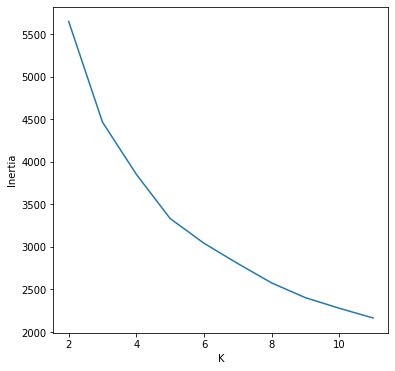

In [11]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize = (6,6))
pd.Series(interias, index = sizes).plot(ax = ax)
ax.set_xlabel('K')
ax.set_ylabel('Inertia')

Scikit-learn has other clustering metrics when the ground truth labels are not known. 

The _Silhouette Coefficient_ is a value between -1 and 1. The higher the score, the better. 1 indicates tight clusters, and 0 means overlapping clusters. From that measure, two clusters gives us the best score. 

The _Calinski-Harabasz Index_ is the ratio between-cluster distance and within-cluster dispersion. A higher score is better. Two clusters gives the best score for this metric. 

The _Davis-Bouldin Index_ is the average similarity between each cluster and the closest cluster. Scores range from 0 and up. 0 indicates better clustering. 

C:\Users\alber\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([[<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>],
       [<AxesSubplot:xlabel='k'>, <AxesSubplot:xlabel='k'>]], dtype=object)

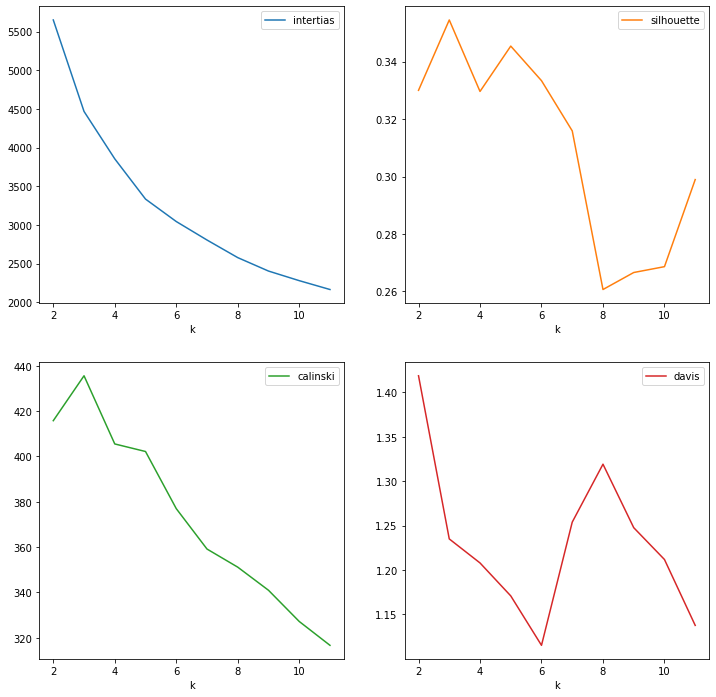

In [13]:
from sklearn import metrics

inertias = []
sils = []
chs = []
dbs = []
sizes = range(2,12)

for k in sizes: 
    k2 = KMeans(random_state=42, n_clusters = k)
    k2.fit(X)
    inertias.append(k2.inertia_)
    sils.append(
    metrics.silhouette_score(X,k2.labels_)
    )
    chs.append(
    metrics.calinski_harabasz_score(X, k2.labels_)
    )
    dbs.append(
    metrics.davies_bouldin_score(X, k2.labels_)
    )
    
fig,ax = plt.subplots(figsize = (12,12))
pd.DataFrame({
    'intertias' : interias,
    'silhouette' : sils,
    'calinski' : chs,
    'davis' : dbs,
    'k' : sizes
    
    
}).set_index('k').plot(ax = ax, subplots = True, layout = (2,2))

Another technique for determining clusters is to visualize the silhoutte scores for each cluster. 

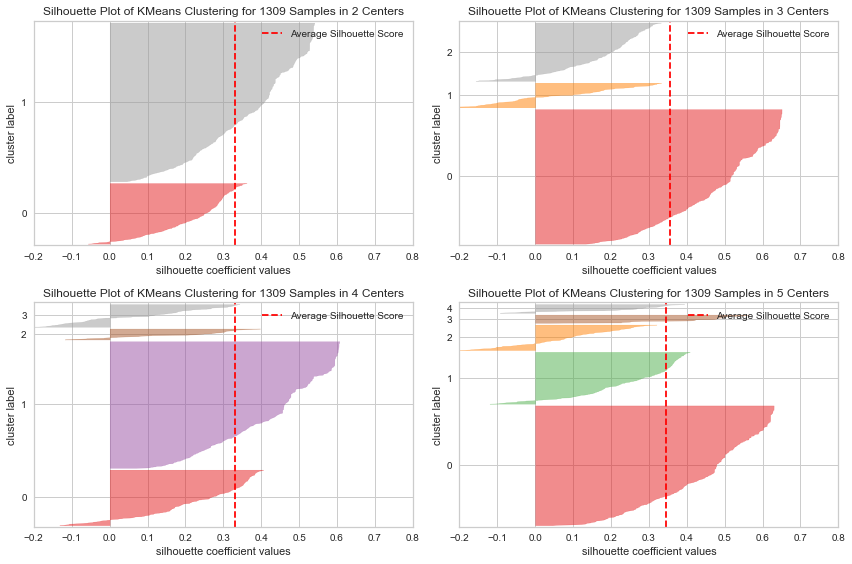

In [15]:
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

fig, axes = plt.subplots(2,2, figsize = (12,8))
axes = axes.reshape(4)
for i, k in enumerate(range(2,6)):
    ax = axes[i]
    sil = SilhouetteVisualizer(
    KMeans(n_clusters = k, random_state = 42), ax = ax)
    sil.fit(X)
    sil.finalize()
    ax.set_xlim(-0.2, 0.8)

plt.tight_layout()

The vertical dotted red line in this plot is the average score. One way to interpret it is to make sure that each cluster bumps out above the average, and the cluster scores look decent. 

## Agglomerative Hierarchical Clustering

Agglomerative clustering is another methodology. You start off with each sample in its own cluster. Then you combine the 'nearest0 clusters. Repeat until done while keeping track of the nearest size. 

When you have finished this, you will have a _dendogram_ or a tree that tracks when clusters were created and what the distance metric was. You can use the scipy library to visualize the dendogram. 

We can use scipy to create a dendogram. 

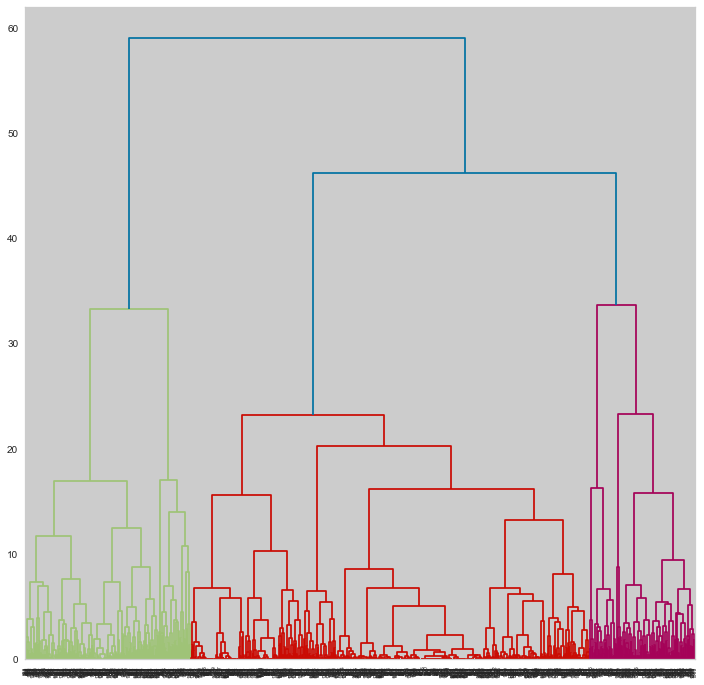

In [18]:
from scipy.cluster import hierarchy


fig,ax = plt.subplots(figsize =(12,12))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X, method = 'ward')
)

As you can see, if you have many samples the leaf nodes are hard to read. 

Once you have the dendogram, you have all the clusters from one to the size of the samples. The heights represent how similar clusters are when they are joined. In order to find how many clusters are in the data, you would want to 'cut' a horizontal line through where it would cross the tallest lines. 

In this case, it looks like when you perform that cut, you have three clusters. 

The previous plot was a little noisy with all of the samples in it. You can also use the `truncate_mode` parameter to combine the leaves into a single node:

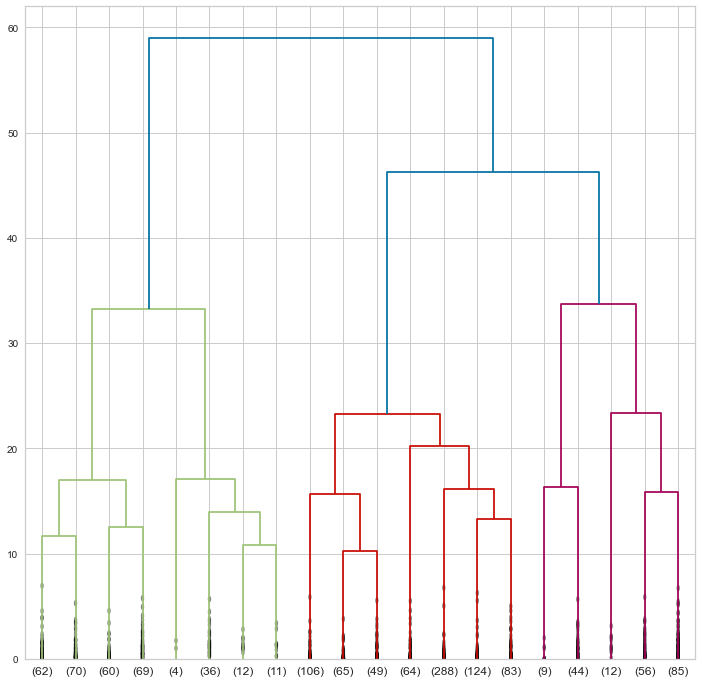

In [19]:
from scipy.cluster import hierarchy

fig,ax = plt.subplots(figsize = (12,12))
dend = hierarchy.dendrogram(
    hierarchy.linkage(X, method = 'ward'),
    truncate_mode= 'lastp', 
    p = 20, 
    show_contracted= True
)

Once we know how many clusters we need, we can use scikitlearn to create a model:

In [20]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(
                n_clusters= 4,
                affinity= 'euclidean',
                linkage= 'ward'
)
ag.fit(X)

AgglomerativeClustering(n_clusters=4)

__NOTE__: The fastcluster package provides an optimal agglomerative clustering package if the scikitlearn implementation is too slow. 

## Understanding Clusters

Using K-means on the Titanic dataset, we will make two clusters. We can use grouping the grouping functionality in pandas to examine the difference in the clusters. The code bolow examines the mean and variance for each feature. It appears that the mean value for pclass varies quite a bit. 

In [22]:
y = pd.read_excel('y.xls')

In [23]:
km = KMeans(n_clusters=2)
km.fit(X)
labels = km.predict(X)
X.assign(cluster = labels, survived = y.survived).groupby('cluster').agg(['mean', 'var']).T

cluster                 0         1
pclass     mean -1.417932  0.542019
           var   0.137226  0.267902
age        mean  0.824752 -0.315270
           var   1.096626  0.605447
sibsp      mean -0.066094  0.025265
           var   0.331636  1.254856
parch      mean -0.018798  0.007186
           var   0.701641  1.115783
fare       mean  0.915067 -0.349793
           var   2.313904  0.057812
sex_female mean  0.430939  0.327350
           var   0.245910  0.220425
embarked_S mean  0.585635  0.741288
           var   0.243339  0.191983
embarked_Q mean  0.016575  0.123548
           var   0.016345  0.108398
embarked_C mean  0.392265  0.135164
           var   0.239054  0.117018
survived   mean  0.582873  0.305174
           var   0.243806  0.212267

<AxesSubplot:>

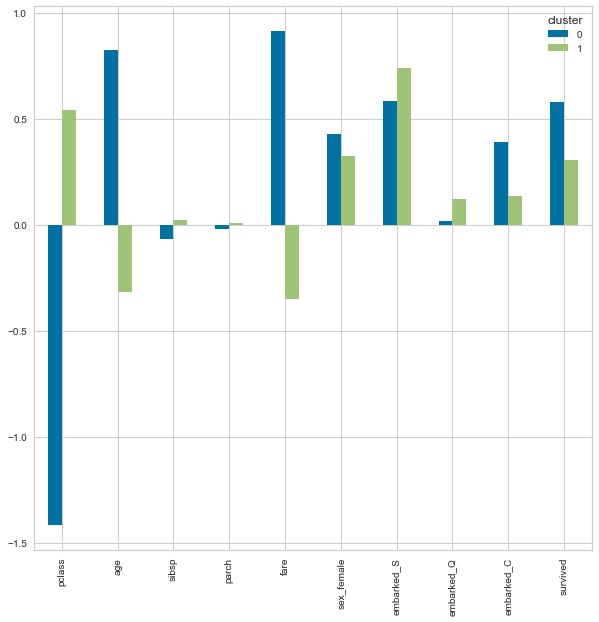

In [24]:
fig, ax = plt.subplots(figsize = (10,10))
X.assign(cluster = labels, survived = y.survived).groupby('cluster').mean().T.plot.bar(ax=ax)

We can also plot PCA components colored by the cluster label.

In [25]:
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler

pca = PCA(random_state=42)
X_pca = pca.fit_transform(X)

C:\Users\alber\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

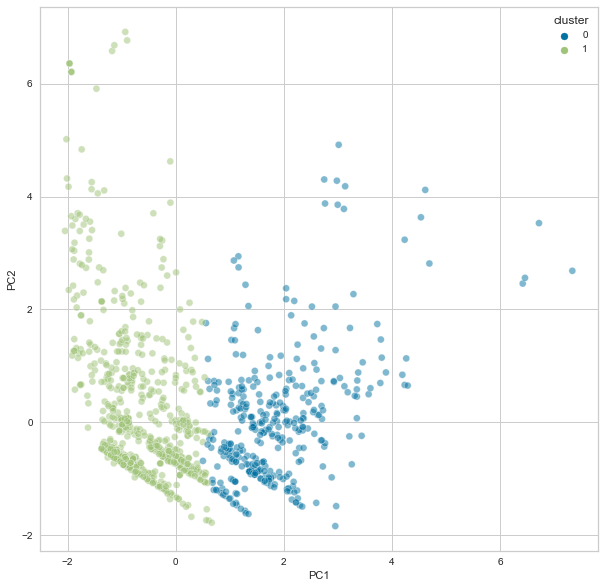

In [29]:
import seaborn as sns

fig,ax = plt.subplots(figsize = (10,10))
sns.scatterplot('PC1', 'PC2', data = X.assign(PC1 = X_pca[:,0],
                                         PC2 = X_pca[:,1],
                                         cluster = labels,),
           hue = 'cluster', alpha = 0.5, ax = ax )

If we want to examine a single feature, we can use the pandas `.describe` method:

In [31]:
X.assign(cluster = labels).groupby('cluster').age.describe().T

cluster,0,1
count,362.000000,947.000000
mean,0.824752,-0.315270
std,1.047199,0.778105
min,-2.161393,-2.219870
25%,0.028273,-0.673461
50%,0.853465,-0.269770
75%,1.570008,0.028273
max,4.004761,3.088778


We can also create a surrogate model to explain the clusters. Here we use a decision tree to explain them. This also shows that pclass (which had a large difference in the mean) is very important:

In [33]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X,labels)
for col, val in sorted(zip(X.columns, dt.feature_importances_), key = lambda col_val : col_val[1], reverse = True):
    print(f'{col:10}{val:10.3f}')

pclass         0.908
age            0.076
fare           0.013
embarked_C     0.003
sibsp          0.000
parch          0.000
sex_female     0.000
embarked_S     0.000
embarked_Q     0.000


In [39]:
import pydotplus
from io import StringIO
from sklearn.tree import export_graphviz

dot_data = StringIO()
export_graphviz(dt, 
               out_file= dot_data, 
                feature_names= X.columns,
                class_names = ['0','1'], 
                max_depth = 2, 
                filled = True)

g = pydotplus.graph_from_dot_data(dot_data.getvalue())